### 2D advection Level Set Method on cartesian mesh

In [768]:
using Plots
using LinearAlgebra

##### Functions

In [880]:
# Homogeneous 2D neumann boundary conditions (to be used)
function neumann_top(phi,N)
    phi[2,2:N+1]
end
function neumann_bottom(phi,N)
    phi[end-1,2:N+1]
end
function neumann_left(phi,N)
    phi[2:N+1,2]
end
function neumann_right(phi,N)
    phi[2:N+1,end-1]
end

# Cartesian grid initialisation 
function grid(L0,h,N)
    [ -L0 + h*(i-1) for i=1:N+1, j = 1:N+1]
end

# Cell centers for VOF formulation
function cell_center(X,N)
    0.5(X[1:N,1:N]+X[2:N+1,2:N+1])
end

# Initialisation of level set function phi 
function init_circle(X,Y,radius,N)
    R = radius*[1 for i = 1:N, j = 1:N];
    X.^2 + Y.^2 - R
end

# On a 3x3 stencil, if the integrated flux from adjacent to central cell
# is negative, mark them and use them. (Mikula, 2007)
function find_inflow(phibc,i,j,h,c)
        stencil = Array{CartesianIndex{2},1}(undef, 0); # Coordinates of cells of interest
        for k = i-1:2:i+1 # the 2 adjacent cells in the x direction
            # Computation of integrated flux
            a = h*(-c)*((phibc[k,j]-phibc[i,j])/sqrt(((phibc[k,j]-phibc[i,j])^2))) 
            if a < 0.
                # add the cell coordinates to the array
                push!(stencil,CartesianIndex(k, j))
            end
        end
        for k = j-1:2:j+1 # the 2 adjacent cells in the y direction
            a = h*(-c)*((phibc[i,k]-phibc[i,j])/sqrt(((phibc[i,k]-phibc[i,j])^2)))
            if a < 0.
                push!(stencil,CartesianIndex(i, k))
            end
        end
        stencil
end

find_inflow (generic function with 2 methods)

##### Parameters

In [887]:
N = 80 # number of grid points
L0 = 2. # domain size
h = 2*L0/N # grid spacing

radius = 1. # initial radius of the circle
c = 1. # constant driving force

CFL = 0.5
Tmax = 0.2
#tau = 0.001 # time step (respects CFL condition)
tau = CFL*h^2 # time step (respects CFL condition)
nt = trunc(Int, Tmax/tau)

159

##### Initialisation

In [892]:
# Mesh initalisation
X = cell_center(transpose(grid(L0,h,N)),N);
Y = cell_center(grid(L0,h,N),N);

# Level set function initialisation
phibc = zeros(N+2,N+2)
phibc[2:N+1,2:N+1] = init_circle(X,Y,radius,N)
#phibc = phibc/findmax(phibc)[1]
# Neumann BC with one ghost layer
phibc[1,2:N+1] = phibc[2,2:N+1];
phibc[end,2:N+1] = phibc[end-1,2:N+1]
phibc[2:N+1,1] = phibc[2:N+1,2]
phibc[2:N+1,end] = phibc[2:N+1,end-1]

phi0 = phibc[2:N+1,2:N+1];

##### Main loop

In [889]:
pyplot()

Plots.PyPlotBackend()

In [894]:
for n = 1:nt # Time loop
    for i = 2:N+1 # x loop
        for j = 2:N+1 # y loop
            lv = 0. # initialisation of rhs
            cm = 0.
            stc = find_inflow(phibc,i,j,h,c) # find the cells of interest
            
            if length(stc) > 0 # if no cell is found then phi(n+1) = phi(n)
                for k = 1:length(stc)
                    # for each cell of interest compute
                    # the "leaving" and "coming" terms
                    lv += (-1.) *(-c)*h*(phibc[stc[k]]-phibc[i,j])/sqrt((phibc[stc[k]]-phibc[i,j])^2)
                    cm += (-1.) *(-c)*h*phibc[stc[k]]*(phibc[stc[k]]-phibc[i,j])/sqrt((phibc[stc[k]]-phibc[i,j])^2)
                end     
            end
            
            # update the level set function
            phibc[i,j] = phibc[i,j]*(1. - (tau/h^2)*lv) + (tau/h^2)*cm
            
        end
    end
#contour(X,Y,[phibc[2:N+1,2:N+1],phi0,phi_a],nlevels=1,clims=(0,2))    
# Neumann BC applied at each time step    
phibc[1,2:N+1] = phibc[2,2:N+1];
phibc[end,2:N+1] = phibc[end-1,2:N+1];
phibc[2:N+1,1] = phibc[2:N+1,2];
phibc[2:N+1,end] = phibc[2:N+1,end-1];
end    

##### Post-processing

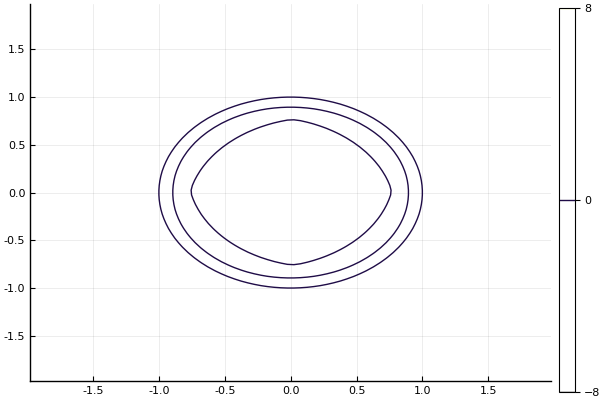

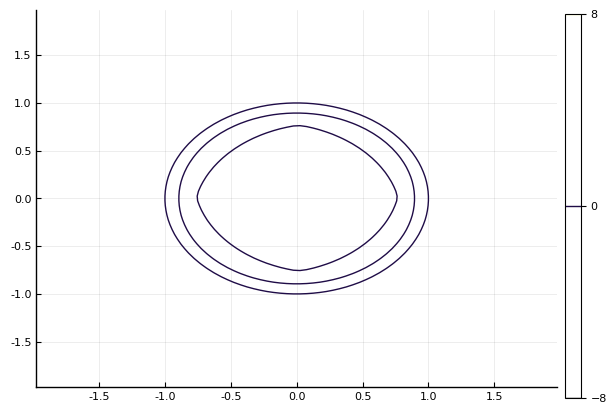

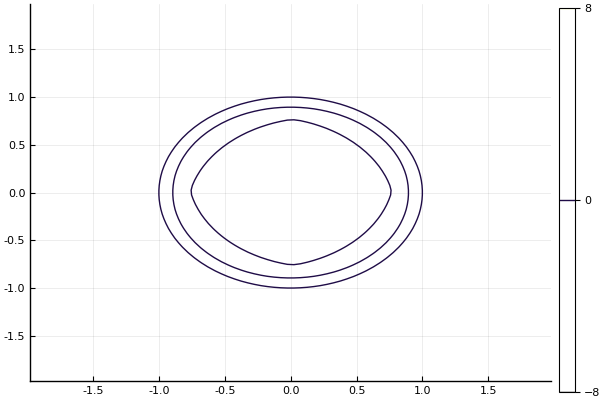

In [906]:
rad_a = radius - Tmax;
phi_a = init_circle(X,Y,rad_a,N)
contour(X,Y,[phibc[2:N+1,2:N+1],phi0,phi_a],levels=0,label=["Initial" "Analytical" "Numerical" ]) 

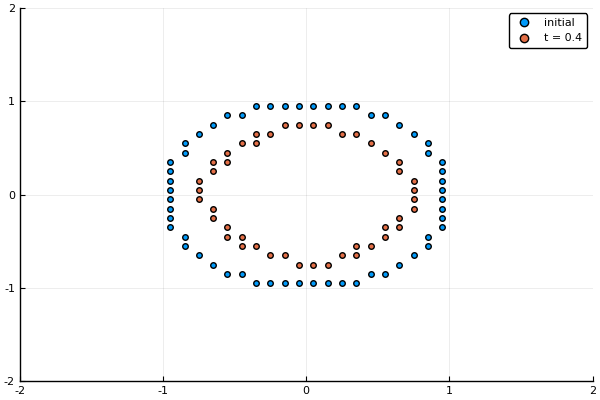

In [815]:
# Find intersection of phi with 0-(x,y) plane
# phi < 0 inside 
# phi > 0 outside
pos = findall(x->abs(x)<h,phibc[2:N+1,2:N+1])
pos2 = findall(x->abs(x)<h,phi0)

# Plot initial and final circle
scatter(X[pos2],Y[pos2],label = "initial", xlims = (-L0,L0), ylims = (-L0,L0))
scatter!(X[pos],Y[pos],label = "t = 0.4", xlims = (-L0,L0), ylims = (-L0,L0))

#savefig("/Users/tomas/PhD/2019-2020/julia/JuLSM/shrinking_circle.png")

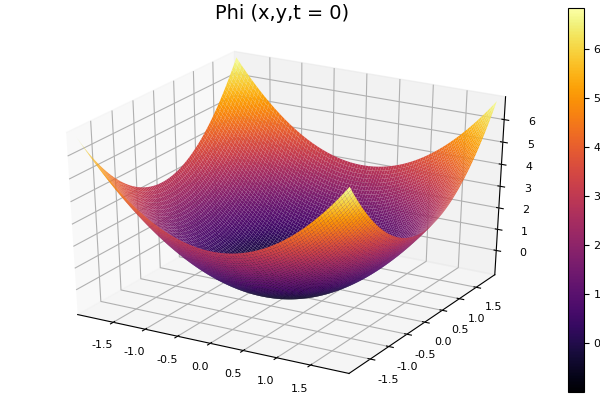

In [807]:
pyplot()
plot(X,Y,phi0 ,st=:surface,camera=(30,30),title = "Phi (x,y,t = 0)")
#savefig("/Users/tomas/PhD/2019-2020/julia/JuLSM/Phi_t0.png")

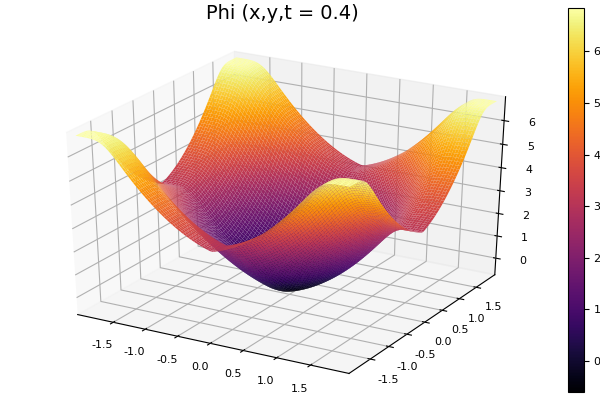

In [793]:
plot(X,Y,phibc[2:N+1,2:N+1],st=:surface,camera=(30,30),title = "Phi (x,y,t = 0.4)")
#savefig("/Users/tomas/PhD/2019-2020/julia/JuLSM/Phi_t0_4.png")